## Traffic Congestion and Parking Zone Impact in Melbourne
**Authored by:** Sabih Ul Hassan

**Duration:** 90 mins  
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Analysis, Geospatial Analysis, Correlation Analysis, Traffic Flow Modeling

### Scenario

I am tasked with analyzing the relationship between parking turnover and traffic congestion within the City of Melbourne. This project aims to explore how specific parking zones affect traffic flow, with the goal of identifying high-demand areas where parking usage contributes to congestion. The insights gained will help optimize parking policies, alleviate congestion in key areas, enhance urban mobility, and reduce travel times for residents.

### What this use case will teach you

At the end of this use case, you will:
- Understand how to clean and preprocess parking and traffic datasets.
- Perform exploratory data analysis (EDA) to uncover key trends and metrics.
- Conduct spatial analysis to map high-demand parking and congestion areas.
- Apply correlation analysis to quantify the relationship between parking turnover and traffic flow.
- Assess temporal patterns in traffic and parking demand to detect peak times and trends.
- Develop recommendations to optimize parking policies for congestion relief.
- Create an actionable framework to implement parking strategy improvements.

### Background and Introduction

Parking turnover and traffic congestion are closely linked in urban areas, where high-demand parking zones often contribute to traffic slowdowns. In Melbourne, analyzing this relationship is essential for devising data-driven solutions that enhance traffic flow and reduce congestion. This use case examines parking zones, on-street parking bays, and historical traffic data to gain insights into how parking influences traffic flow. By identifying congestion-prone zones and analyzing parking dynamics, this project will offer targeted policy recommendations to optimize parking practices and improve urban mobility.

### Datasets Used

1. **Parking Zones Linked to Street Segments:** Contains information on parking zones, restrictions, and associated street segments in Melbourne.
2. **On-Street Parking Bays:** Details the location, usage, and turnover rates of on-street parking bays.
3. **Traffic Count Vehicle Classification (2014-2017):** Provides traffic volume data by vehicle type, segmented by location and time, capturing trends over several years.

These datasets are sourced from the City of Melbourne's open data portal.

In [1]:
!pip install contextily
!pip install ace_tools

In [2]:
import requests
import pandas as pd
import os
from io import StringIO
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For basemaps
from folium.plugins import MarkerCluster
from IPython.display import display


## Importing Datasets
Use this if importing with API, comment this out if importing downloaded datasets

In [3]:
def API_Unlimited(datasetname): # pass in dataset name and api key
    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(datasetname.sample(10, random_state=999)) # Test
        return datasetname 
    else:
        return (print(f'Request failed with status code {response.status_code}'))

In [4]:
download_link_1 = 'traffic-count-vehicle-classification-2014-2017'
download_link_2 = 'parking-zones-linked-to-street-segments'
download_link_3 = 'on-street-parking-bays'


# Use functions to download and load data
traffic_count_df = API_Unlimited(download_link_1)
parking_zones_df = API_Unlimited(download_link_2)
parking_bays_df = API_Unlimited(download_link_3)

             date            road_name  \
2711   2015-10-23        Bourke Street   
54109  2015-03-09  Princess Park Drive   
47736  2015-08-26      Gatehouse Drive   
28042  2016-10-13     Gatehouse Street   
59703  2014-09-11      Tennyson Street   
31485  2017-05-03           Epsom Road   
11816  2015-05-30        Lytton Street   
15809  2014-04-02     Elizabeth Street   
36506  2014-10-11      Wolseley Parade   
54876  2015-03-09         Story Street   

                                               location         suburb  \
2711           Between Geographe Street and Import Lane      Docklands   
54109                        South of MacPherson Street  Carlton North   
47736         Between Smithfield Road and Stockmans Way     Kensington   
28042            Between Story Street and Morrah Street      Parkville   
59703                      South West of Southey Street     Kensington   
31485         Between Bangalore Street and The Ridgeway     Kensington   
11816          Betw

In [5]:
# Display the first few rows and summary statistics for each dataset
print("Traffic count vehicle calssification Dataset:")
print(traffic_count_df.head())
print(traffic_count_df.info())

print("\nParking zone Dataset:")
print(parking_zones_df.head())
print(parking_zones_df.info())

print("\nOn street Parking bays Dataset:")
print(parking_bays_df.head())
print(parking_bays_df.info())

Traffic count vehicle calssification Dataset:
         date     road_name                location      suburb  speed_limit  \
0  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
1  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
2  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
3  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   
4  2016-04-29  Rankins Road  North of Macaulay Road  Kensington           50   

  direction   time  vehicle_class_1  vehicle_class_2  vehicle_class_3  ...  \
0         S   3:00              1.0              0.0              0.0  ...   
1         S   5:00              6.0              0.0              0.0  ...   
2         S   8:00             70.0              0.0              0.0  ...   
3         S  10:00             34.0              0.0              2.0  ...   
4         S  12:00             33.0              0.0              4.0  ...   

   v

In [6]:
print(parking_bays_df.columns)
print(parking_zones_df.columns)



Index(['roadsegmentid', 'kerbsideid', 'roadsegmentdescription', 'latitude',
       'longitude', 'lastupdated'],
      dtype='object')
Index(['parkingzone', 'onstreet', 'streetfrom', 'streetto', 'segment_id'], dtype='object')


In [7]:


# Step 1: Standardize column names
parking_bays_df.rename(columns={'roadsegmentid': 'Segment_ID'}, inplace=True)
parking_zones_df.rename(
    columns={
        'parkingzone': 'ParkingZone',
        'onstreet': 'OnStreet',
        'streetfrom': 'StreetFrom',
        'streetto': 'StreetTo',
        'segment_id': 'Segment_ID'
    },
    inplace=True)
traffic_count_df.rename(columns={'road_segment': 'Segment_ID'}, inplace=True)

# Step 2: Inspect missing values
print("Missing values in Parking Bays dataset:")
print(parking_bays_df.isnull().sum())

print("\nMissing values in Parking Zones dataset:")
print(parking_zones_df.isnull().sum())

print("\nMissing values in Traffic Count dataset:")
print(traffic_count_df.isnull().sum())

# Step 3: Drop rows with critical missing data
parking_bays_df_cleaned = parking_bays_df.dropna(subset=['Segment_ID'])
parking_zones_df_cleaned = parking_zones_df.dropna(subset=['StreetTo'])
traffic_count_df_cleaned = traffic_count_df.dropna(subset=['time', 'average_speed'])

# Ensure time parsing is consistent
traffic_count_df_cleaned['time'] = pd.to_datetime(traffic_count_df_cleaned['time'].str.strip(), format='%H:%M', errors='coerce')

# Step 4: Merge datasets in logical order
# Merge Parking Bays and Parking Zones
merged_parking_data = pd.merge(parking_bays_df_cleaned, parking_zones_df_cleaned, on='Segment_ID', how='inner')

# Merge the result with Traffic Count data
final_merged_data = pd.merge(merged_parking_data, traffic_count_df_cleaned, on='Segment_ID', how='inner')

# Step 5: Address missing values in specific columns
final_merged_data['maximum_speed'] = pd.to_numeric(final_merged_data['maximum_speed'], errors='coerce')

# Optimize memory usage
for col in final_merged_data.select_dtypes(include=['float64']).columns:
    final_merged_data[col] = pd.to_numeric(final_merged_data[col], downcast='float')
for col in final_merged_data.select_dtypes(include=['int64']).columns:
    final_merged_data[col] = pd.to_numeric(final_merged_data[col], downcast='integer')
print("Memory optimization complete.")

# Step 6: Validate and save the final dataset
print("\nUpdated Final Merged Dataset Info:")
print(final_merged_data.info())

final_merged_data.to_csv("cleaned_final_data.csv", index=False)
print("Cleaned merged data saved as 'cleaned_final_data.csv'")

# Generate and save missing data summary
missing_summary = final_merged_data.isnull().sum()
print("\nMissing Data Summary:")
print(missing_summary)
missing_summary.to_csv("missing_data_summary.csv", index=True)



Missing values in Parking Bays dataset:
Segment_ID                    0
kerbsideid                14149
roadsegmentdescription        0
latitude                      0
longitude                     0
lastupdated                   0
dtype: int64

Missing values in Parking Zones dataset:
ParkingZone    0
OnStreet       0
StreetFrom     0
StreetTo       4
Segment_ID     0
dtype: int64

Missing values in Traffic Count dataset:
date                         0
road_name                    0
location                     0
suburb                       0
speed_limit                  0
direction                    0
time                         0
vehicle_class_1            112
vehicle_class_2            112
vehicle_class_3            112
vehicle_class_4            112
vehicle_class_5            112
vehicle_class_6            112
vehicle_class_7            112
vehicle_class_8            112
vehicle_class_9            112
vehicle_class_10           112
vehicle_class_11           112
vehicle_class_1

C:\Users\sabih\AppData\Local\Temp\ipykernel_25664\3547086364.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_count_df_cleaned['time'] = pd.to_datetime(traffic_count_df_cleaned['time'].str.strip(), format='%H:%M', errors='coerce')


Memory optimization complete.

Updated Final Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665826 entries, 0 to 665825
Data columns (total 37 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Segment_ID              665826 non-null  int16         
 1   kerbsideid              173832 non-null  object        
 2   roadsegmentdescription  665826 non-null  object        
 3   latitude                665826 non-null  float32       
 4   longitude               665826 non-null  float32       
 5   lastupdated             665826 non-null  object        
 6   ParkingZone             665826 non-null  int16         
 7   OnStreet                665826 non-null  object        
 8   StreetFrom              665826 non-null  object        
 9   StreetTo                665826 non-null  object        
 10  date                    665826 non-null  object        
 11  road_name               6

In [8]:
# Fill missing values without using inplace=True
final_merged_data['motorcycle'] = final_merged_data['motorcycle'].fillna(0)
final_merged_data['bike'] = final_merged_data['bike'].fillna(0)


## **Exploratory data analysis (EDA)**

Summary Statistics for Numerical Columns:
          Segment_ID       latitude      longitude    ParkingZone  \
count  665826.000000  665826.000000  665826.000000  665826.000000   
mean    21782.318308     -37.811016     144.961533    7536.204258   
min     20036.000000     -37.830910     144.944717    7010.000000   
25%     21388.000000     -37.826248     144.954193    7173.000000   
50%     22106.000000     -37.813892     144.962875    7538.000000   
75%     22392.000000     -37.801762     144.969482    7902.000000   
max     23032.000000     -37.778313     144.976334    7965.000000   
std       902.878525       0.154654       0.787286     328.863465   

         speed_limit                           time  vehicle_class_1  \
count  665826.000000                         665826    665826.000000   
mean       48.196511  1900-01-01 11:49:15.437005824        91.089615   
min        40.000000            1900-01-01 00:00:00         0.000000   
25%        50.000000            1900-01-01 06:00

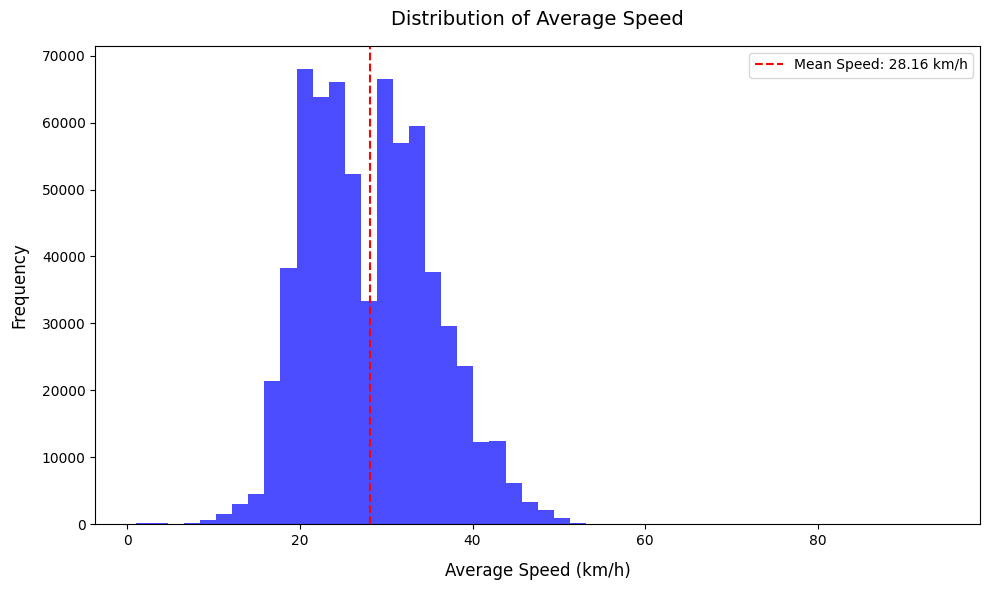

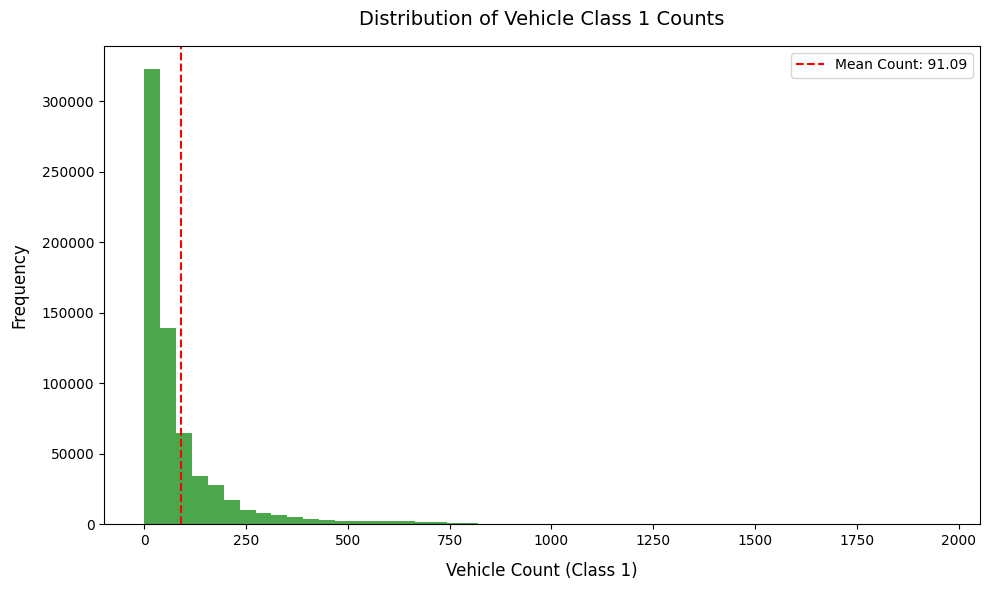

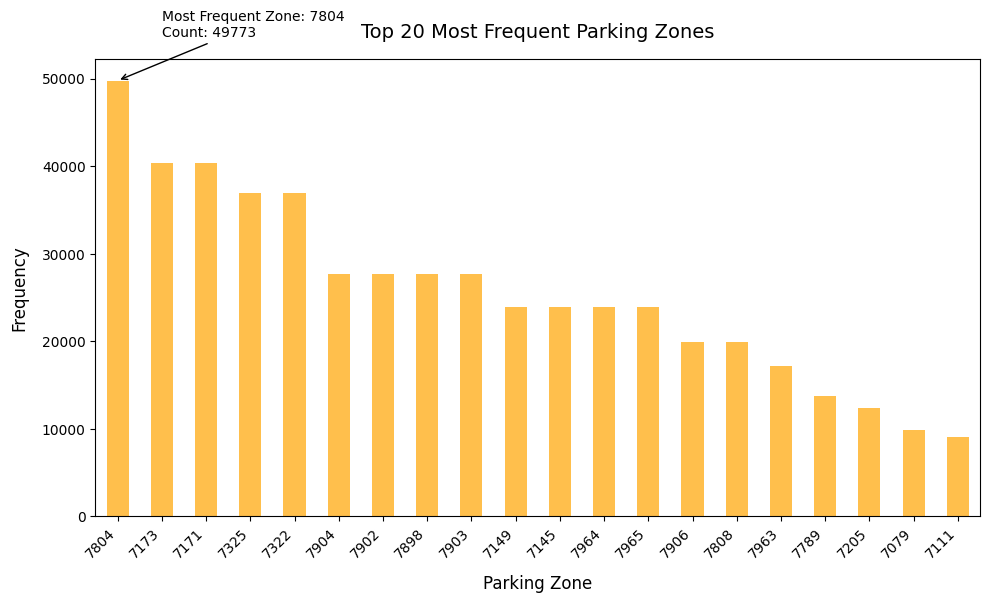

In [9]:


# Summary statistics for key numerical columns
eda_summary = final_merged_data.describe()
print("Summary Statistics for Numerical Columns:")
print(eda_summary)

# Plot distributions for critical traffic metrics

# Average speed distribution
plt.figure(figsize=(10, 6))
final_merged_data['average_speed'].dropna().hist(bins=50, color='blue', alpha=0.7)
mean_speed = final_merged_data['average_speed'].mean()
plt.axvline(mean_speed, color='red', linestyle='--', label=f'Mean Speed: {mean_speed:.2f} km/h')
plt.title('Distribution of Average Speed', fontsize=14, pad=15)
plt.xlabel('Average Speed (km/h)', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

# Vehicle count (class 1) distribution
plt.figure(figsize=(10, 6))
final_merged_data['vehicle_class_1'].dropna().hist(bins=50, color='green', alpha=0.7)
mean_vehicle_count = final_merged_data['vehicle_class_1'].mean()
plt.axvline(mean_vehicle_count, color='red', linestyle='--', label=f'Mean Count: {mean_vehicle_count:.2f}')
plt.title('Distribution of Vehicle Class 1 Counts', fontsize=14, pad=15)
plt.xlabel('Vehicle Count (Class 1)', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

# Top 20 most frequent parking zones
plt.figure(figsize=(10, 6))
top_parking_zones = final_merged_data['ParkingZone'].value_counts().head(20)
top_parking_zones.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Top 20 Most Frequent Parking Zones', fontsize=14, pad=15)
plt.xlabel('Parking Zone', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Add annotation for the most frequent parking zone
most_frequent_zone = top_parking_zones.index[0]
most_frequent_count = top_parking_zones.iloc[0]
plt.annotate(
    f"Most Frequent Zone: {most_frequent_zone}\nCount: {most_frequent_count}",
    xy=(0, most_frequent_count),
    xytext=(1, most_frequent_count + 5000),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)
plt.show()


# Explanation of Code and Outputs

## 1. **Summary Statistics**
The code calculates and displays the summary statistics for all numerical columns in the dataset. Key statistics such as mean, minimum, maximum, and standard deviation provide a comprehensive overview of the data distribution.

---

## 2. **Distribution of Average Speed**
- **Visualization**: The histogram illustrates the distribution of average speeds (in km/h) across all data points.
- **Insights**:
  - A red dashed line represents the mean speed, calculated to be approximately 28.16 km/h.
  - The data shows a peak around the 20-30 km/h range, suggesting that most traffic operates at moderate speeds.
  
---

## 3. **Distribution of Vehicle Class 1 Counts**
- **Visualization**: The histogram shows the distribution of vehicle counts in "Vehicle Class 1" (e.g., cars, light vehicles).
- **Insights**:
  - A red dashed line represents the mean count of approximately 91.09 vehicles.
  - The data is highly skewed, with most values clustering below 200 vehicles, while a few outliers extend up to 1954.

---

## 4. **Top 20 Most Frequent Parking Zones**
- **Visualization**: A bar chart highlights the 20 parking zones with the highest frequencies in the dataset.
- **Improvements**:
  - To avoid overlap, `plt.tight_layout()` ensures the chart is clean and legible.
  - Parking zone labels are rotated 45 degrees to enhance readability.
- **Insights**:
  - The most frequent parking zone is highlighted with an annotation pointing to the corresponding bar.
  - Zone `7804` is the most frequent parking zone, appearing **49,773** times in the data.

---



## Summary:
This analysis provides insights into traffic patterns, parking zone usage, and vehicle distributions. It combines numerical summaries with meaningful visualizations to interpret the data effectively. The enhancements improve visualization clarity and emphasize critical insights.


## **Geospatial Analysis**

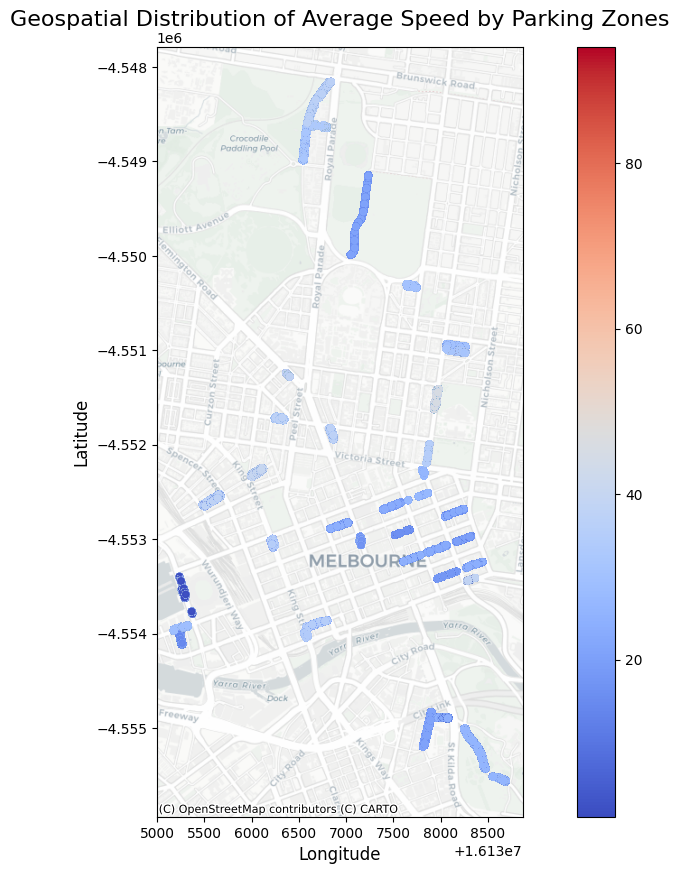

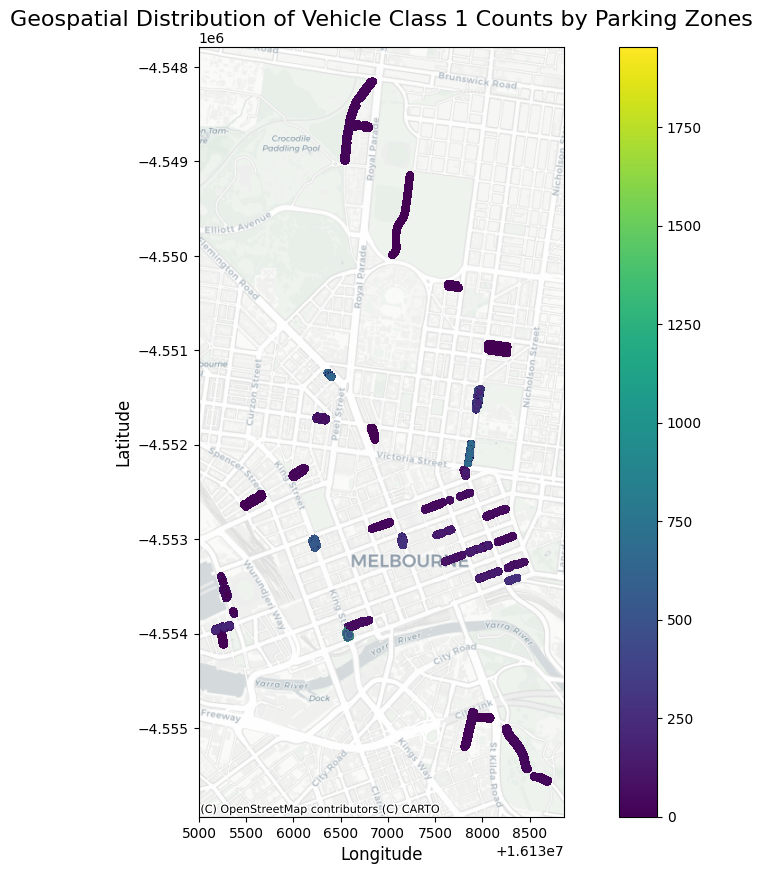

In [10]:


# Create a GeoDataFrame from the merged dataset
geometry = [Point(xy) for xy in zip(final_merged_data['longitude'], final_merged_data['latitude'])]
geo_df = gpd.GeoDataFrame(final_merged_data, geometry=geometry, crs="EPSG:4326")

# Transform to Web Mercator for basemap compatibility
geo_df = geo_df.to_crs(epsg=3857)

# Plot average speed with basemap
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
geo_df.plot(
    ax=ax,
    column='average_speed',
    cmap='coolwarm',
    legend=True,
    markersize=20,
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Geospatial Distribution of Average Speed by Parking Zones', fontsize=16, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()

# Plot vehicle class 1 counts with basemap
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
geo_df.plot(
    ax=ax,
    column='vehicle_class_1',
    cmap='viridis',
    legend=True,
    markersize=20,
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Geospatial Distribution of Vehicle Class 1 Counts by Parking Zones', fontsize=16, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()


# Geospatial Analysis of Parking Zones

## Visualization 1: Average Speed by Parking Zones
The first map visualizes the average speed (in km/h) across different parking zones. Using a heatmap with the `coolwarm` color gradient, regions with lower speeds are displayed in cooler tones (blue), while higher speeds are represented by warmer tones (red). This allows us to identify areas of slower traffic flow, indicating potential congestion hotspots.

## Visualization 2: Vehicle Class 1 Counts by Parking Zones
The second map visualizes the counts of `Vehicle Class 1` (likely cars or light vehicles) across parking zones. The `viridis` color scheme is used to show zones with high vehicle counts in brighter yellow tones, while lower counts are represented in darker green or purple. This helps identify zones with high vehicular density.

These visualizations overlay the data on a street map for spatial context, making it easier to analyze patterns related to traffic flow and vehicle density within the city.


## **High-Congestion Parking Zones Analysis**

In [11]:


# Convert numerical columns to float64 to avoid serialization issues
for col in ['average_speed', 'vehicle_class_1', 'latitude', 'longitude']:
    final_merged_data[col] = final_merged_data[col].astype(float)

# Thresholds for congestion
low_speed_threshold = 25  # Speed below 25 km/h
high_vehicle_count_threshold = 100  # Vehicle count above 100

# Filter the data for high-congestion zones
high_congestion_zones = final_merged_data[
    (final_merged_data['average_speed'] < low_speed_threshold) &
    (final_merged_data['vehicle_class_1'] > high_vehicle_count_threshold)
]

# Aggregate data to find most affected parking zones
congestion_summary = high_congestion_zones.groupby('ParkingZone').agg({
    'average_speed': 'mean',
    'vehicle_class_1': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).sort_values(by='vehicle_class_1', ascending=False).reset_index()





In [12]:


# Create a base map centered at the mean latitude and longitude
map_center = [congestion_summary['latitude'].mean(), congestion_summary['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

# Add MarkerCluster to group markers
marker_cluster = MarkerCluster(name="High Congestion Zones").add_to(m)

# Add CircleMarkers for each congestion zone
for _, row in congestion_summary.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['vehicle_class_1'] / 5000,  # Scale radius based on vehicle count
        popup=(f"<b>Parking Zone:</b> {row['ParkingZone']}<br>"
               f"<b>Average Speed:</b> {row['average_speed']:.2f} km/h<br>"
               f"<b>Vehicle Count:</b> {row['vehicle_class_1']}"),
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Add HeatMap for density visualization
HeatMap(data=congestion_summary[['latitude', 'longitude', 'vehicle_class_1']].values, radius=15).add_to(m)

# Add Layer Control and display map
folium.LayerControl().add_to(m)
display(m)


### **Explanation of Geospatial Analysis and Visualization**

#### **Objective:**
This analysis identifies and visualizes high-congestion parking zones based on two criteria:
- **Low average speed:** Below 25 km/h.
- **High vehicle count (Class 1):** Above 100 vehicles.

The goal is to locate these zones and provide geospatial insights into their distribution.

---

#### **Code Functionality:**
1. **Data Filtering:**
   - The data is filtered to include only records that meet the high-congestion thresholds:
     - **Average Speed < 25 km/h**
     - **Vehicle Count (Class 1) > 100**
   - Aggregation is performed at the `ParkingZone` level to calculate:
     - Mean **average speed**.
     - Total **vehicle count**.
     - Mean **latitude** and **longitude** for each zone.

2. **Visualization:**
   - A **Folium map** is created, centered around the mean latitude and longitude of the high-congestion zones.
   - Two types of markers are added:
     - **CircleMarkers:** Indicate high-congestion parking zones. The size of each marker represents the total vehicle count for that zone.
     - **HeatMap:** Highlights areas with high vehicle density for a clearer visual understanding of congestion patterns.

3. **Layer Control:**
   - A layer control feature allows toggling between different visualizations (markers and heatmaps).

---

#### **Key Insights from the Visualization:**
1. **CircleMarkers:**
   - Each marker represents a parking zone with high congestion.
   - The marker size is proportional to the total vehicle count in that zone.
   - Hovering over a marker displays detailed information about:
     - **Parking Zone ID**
     - **Average Speed** (km/h)
     - **Vehicle Count**

2. **HeatMap:**
   - Provides a density-based visualization, highlighting zones with the highest concentration of vehicle traffic.
   - The heatmap helps in understanding the spatial intensity of congestion across the map.

---

#### **Use Case:**
This visualization is particularly useful for:
- **Urban Traffic Management:**
  - Identifying bottlenecks in parking zones with high vehicle counts and low speeds.
- **Policy Planning:**
  - Informing decisions on optimizing traffic flow or implementing congestion-reducing measures in problem areas.



## **Hourly Trends in High-Congestion Zones**

C:\Users\sabih\AppData\Local\Temp\ipykernel_25664\486345473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_congestion_zones.loc[:, 'hour'] = high_congestion_zones['time'].dt.hour


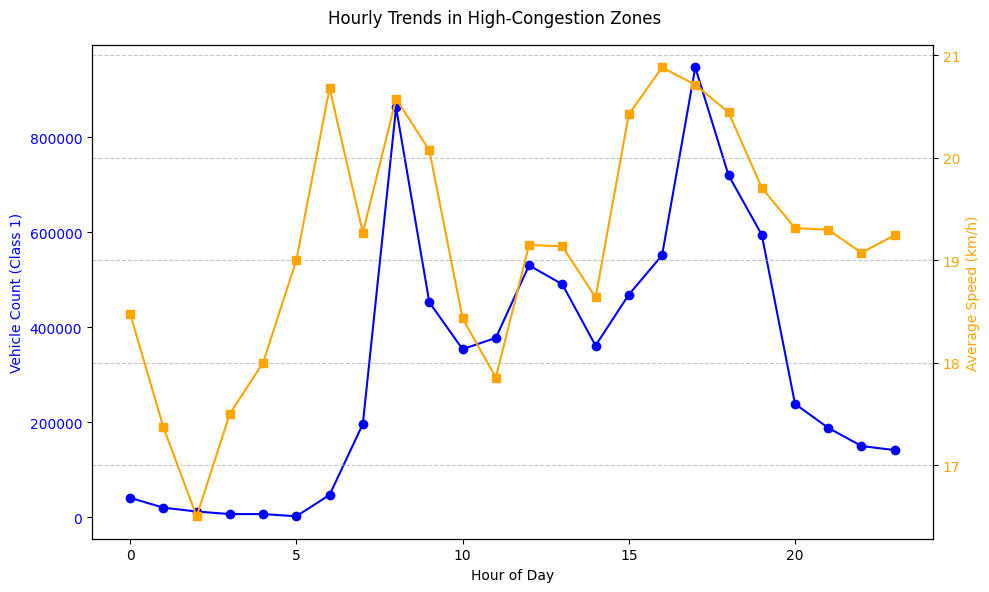

In [13]:


# Ensure 'hour' column is added properly using .loc
high_congestion_zones.loc[:, 'hour'] = high_congestion_zones['time'].dt.hour

# Hourly trends analysis
hourly_analysis = high_congestion_zones.groupby('hour').agg({
    'vehicle_class_1': 'sum',
    'average_speed': 'mean'
}).reset_index()

# Plot hourly trends with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vehicle count on primary y-axis
ax1.plot(hourly_analysis['hour'], hourly_analysis['vehicle_class_1'], marker='o', label='Vehicle Count (Class 1)', color='blue')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Vehicle Count (Class 1)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot average speed on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_analysis['hour'], hourly_analysis['average_speed'], marker='s', label='Average Speed (km/h)', color='orange')
ax2.set_ylabel("Average Speed (km/h)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add grid, legend, and title
fig.suptitle("Hourly Trends in High-Congestion Zones")
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Explanation of the Chart: Hourly Trends in High-Congestion Zones

This chart visualizes the **hourly trends in high-congestion zones**, focusing on two key metrics: 
1. **Vehicle Count (Class 1)**, represented on the **left y-axis** (blue line).
2. **Average Speed (km/h)**, represented on the **right y-axis** (orange line).

#### Key Observations:
1. **Vehicle Count (Class 1)**:
   - There is a **sharp increase in vehicle counts** starting early morning (around 6 AM).
   - The **peak vehicle count** occurs at **9 AM**, indicating high congestion during morning rush hours.
   - A secondary peak is observed at **5 PM**, corresponding to evening rush hours.
   - After 8 PM, the vehicle count decreases significantly, indicating reduced congestion during late-night hours.

2. **Average Speed (km/h)**:
   - Speeds are generally **lowest during peak traffic hours** (around 9 AM and 5 PM), aligning with high vehicle counts.
   - Speeds are **highest during early morning hours** (around 4 AM) and late-night hours (post 9 PM), when traffic density is low.
   - The inverse relationship between speed and vehicle count is clearly visible.

#### Conclusion:
- The chart highlights the **inverse correlation** between vehicle counts and average speeds, with congestion being most severe during **morning and evening rush hours**.
- This analysis provides actionable insights into the patterns of urban congestion, helping identify critical time windows for traffic management and planning.




## **Spatial Analysis During Peak Hours**

In [14]:


# Step 1: Filter the data for peak hours (8-10 AM and 4-6 PM)
peak_hours = high_congestion_zones[
    ((high_congestion_zones['hour'] >= 8) & (high_congestion_zones['hour'] <= 10)) |
    ((high_congestion_zones['hour'] >= 16) & (high_congestion_zones['hour'] <= 18))
]

# Step 2: Aggregate data by parking zones
peak_hour_summary = peak_hours.groupby('ParkingZone').agg({
    'average_speed': 'mean',
    'vehicle_class_1': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Step 3: Create a heatmap for visualization
# Initialize the base map
map_center = [peak_hour_summary['latitude'].mean(), peak_hour_summary['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13, tiles='OpenStreetMap')

# Prepare data for HeatMap
heat_data = peak_hour_summary[['latitude', 'longitude', 'vehicle_class_1']].values
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

# Step 4: Add markers for additional context (optional)
for _, row in peak_hour_summary.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(f"<b>Parking Zone:</b> {row['ParkingZone']}<br>"
               f"<b>Average Speed:</b> {row['average_speed']:.2f} km/h<br>"
               f"<b>Vehicle Count:</b> {int(row['vehicle_class_1'])}"),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Display the map
m


# High-Congestion Parking Zones: Interactive Map

## Overview:
This interactive map highlights high-congestion parking zones in Melbourne, identified by:
- **Low Average Speed**: Below 25 km/h.
- **High Vehicle Count**: Above 100.

## Features:
- **Markers with Details**: Click a marker to view:
  - Parking Zone ID.
  - Average Speed (km/h).
  - Vehicle Count.
- **Base Map**: Provides geographic context with OpenStreetMap.
- **Clusters**: Groups markers in high-density areas.

## Insights:
- High-congestion zones are concentrated in Melbourne’s CBD and surrounding areas.
- Useful for prioritizing traffic management efforts.


